# ssp.train.py

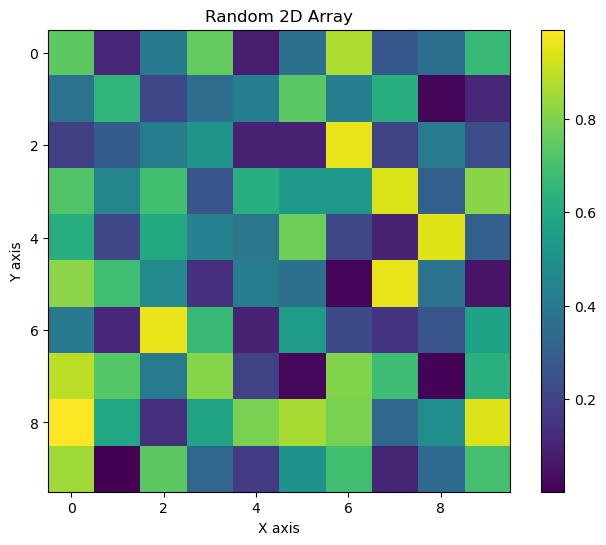

In [1]:
import torch   
import torch.nn as nn 
import torch.nn.functional as F   
import numpy as np
import matplotlib.pyplot as plt
import os
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from scipy import io
import itertools
import math
import datetime
import wandb
import pickle
import json
import time
import sys

# my module import
from modules import *

# modules 폴더에 새모듈.py 만들면
# modules/__init__py 파일에 form .새모듈 import * 하셈
# 그리고 새모듈.py에서 from modules.새모듈 import * 하셈

In [2]:
def cluster_train_system( 
    gpu = 3,
    Conv_net = True,
    SAE_net = True,

    # hyperparameter
    dataset_num = 16,
    spike_length = 50,
    num_cluster = 4,  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
    training_cycle = 2400, # 그 초기 몇개까지만 cluster update할지


    batch_size = 32,
    max_epoch = 7000,
    learning_rate = 0.001,
    normalize_on = False, # True or False #이거 안 씀 # 이거 별로 안 좋은 normalize같음 # 쓸 거면 다른 거 써라.
    need_bias = False,
    # first_layer_no_train = False
    lif_add_at_first = False,
    my_seed = 42,

    TIME = 10, # SAE일 때만 유효
    v_decay = 0.5,
    v_threshold = 0.5,
    v_reset = 10000.0, # 10000이상 일 시 hard reset
    BPTT_on = True,

    SAE_hidden_nomean = True,
    current_time = '20250101_210938_786',

    optimizer = 'Adam',
    coarse_com_mode = True,
    coarse_com_config = (2.0, -2.0), # (max, min)

    sae_l2_norm_bridge = True,
    sae_lif_bridge = False,

    accuracy_check_epoch_term = 5,
    
    lif_add_at_last = False,

    two_channel_input = False,

    lateral_feature_num = 4,

    lc_adc_on = False, 
    ):
    if coarse_com_mode == True:
        assert coarse_com_config[0] > coarse_com_config[1], 'coarse_com_config[0] > coarse_com_config[1]이어야 함'
        assert SAE_net == True, 'coarse_com_mode는 SAE_net이 True일 때만 가능'
    if two_channel_input == True:
        assert Conv_net and coarse_com_mode, 'two_channel_input는 Conv_net이 True일 때만 가능'
    if lc_adc_on == True:
        assert coarse_com_mode and SAE_net, 'lc_adc_on은 coarse_com_mode와 SAE_net이 True일 때만 가능'

    seed_assign(my_seed)
    ## 함수 내 모든 로컬 변수 저장 ########################################################
    hyperparameters = locals()
    print(hyperparameters)
    # JSON으로 저장
    with open(f"result_save/cluster_accuracy_history_{current_time}.json", 'w') as f:
        json.dump(hyperparameters, f, indent=4)
    ######################################################################################

    
    wandb.config.update(hyperparameters)
    wandb.run.name = f'{current_time}_SAE_net_{SAE_net}_v_threshold_{v_threshold}'
    wandb.define_metric("best_mean_cluster_accuracy_post_training_cycle_all_dataset2", summary="max")


    my_path_ground_BH = '/data2/spike_sorting/quiroga/BH/'


    filename = ["C_Easy1_noise005.mat", "C_Easy1_noise01.mat", "C_Easy1_noise015.mat", "C_Easy1_noise02.mat",
                "C_Easy2_noise005.mat", "C_Easy2_noise01.mat", "C_Easy2_noise015.mat", "C_Easy2_noise02.mat",
                "C_Difficult1_noise005.mat", "C_Difficult1_noise01.mat", "C_Difficult1_noise015.mat", "C_Difficult1_noise02.mat",
                "C_Difficult2_noise005.mat", "C_Difficult2_noise01.mat", "C_Difficult2_noise015.mat", "C_Difficult2_noise02.mat"]


    spike_tot = ["BH_Spike_e1n005.npy", "BH_Spike_e1n010.npy", "BH_Spike_e1n015.npy", "BH_Spike_e1n020.npy",
                "BH_Spike_e2n005.npy", "BH_Spike_e2n010.npy", "BH_Spike_e2n015.npy", "BH_Spike_e2n020.npy",
                "BH_Spike_d1n005.npy", "BH_Spike_d1n010.npy", "BH_Spike_d1n015.npy", "BH_Spike_d1n020.npy",
                "BH_Spike_d2n005.npy", "BH_Spike_d2n010.npy", "BH_Spike_d2n015.npy", "BH_Spike_d2n020.npy"]

    label_tot = ["BH_Label_e1n005.npy", "BH_Label_e1n010.npy", "BH_Label_e1n015.npy", "BH_Label_e1n020.npy",
                "BH_Label_e2n005.npy", "BH_Label_e2n010.npy", "BH_Label_e2n015.npy", "BH_Label_e2n020.npy",
                "BH_Label_d1n005.npy", "BH_Label_d1n010.npy", "BH_Label_d1n015.npy", "BH_Label_d1n020.npy",
                "BH_Label_d2n005.npy", "BH_Label_d2n010.npy", "BH_Label_d2n015.npy", "BH_Label_d2n020.npy"]

    template =  ["BH_Spike_TEMPLATE_e1n005.npy", "BH_Spike_TEMPLATE_e1n010.npy", "BH_Spike_TEMPLATE_e1n015.npy", "BH_Spike_TEMPLATE_e1n020.npy",
                "BH_Spike_TEMPLATE_e2n005.npy", "BH_Spike_TEMPLATE_e2n010.npy", "BH_Spike_TEMPLATE_e2n015.npy", "BH_Spike_TEMPLATE_e2n020.npy",
                "BH_Spike_TEMPLATE_d1n005.npy", "BH_Spike_TEMPLATE_d1n010.npy", "BH_Spike_TEMPLATE_d1n015.npy", "BH_Spike_TEMPLATE_d1n020.npy",
                "BH_Spike_TEMPLATE_d2n005.npy", "BH_Spike_TEMPLATE_d2n010.npy", "BH_Spike_TEMPLATE_d2n015.npy", "BH_Spike_TEMPLATE_d2n020.npy"]

    AE_train_path_gt_detect = 'BH_quiroga_training_dataset_gt_detect.pt' 
    AE_test_path_gt_detect = 'BH_quiroga_test_dataset_gt_detect.pt'

    AE_train_path_real_detect = 'BH_quiroga_training_dataset_real_detect.pt'
    AE_test_path_real_detect = 'BH_quiroga_test_dataset_real_detect.pt'

    AE_train_data = AE_train_path_real_detect #AE_train_path_gt_detect #AE_train_path_real_detect
    AE_test_data = AE_test_path_real_detect #AE_test_path_gt_detect  #AE_test_path_real_detect

    # thr_tot = np.array([0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7, 0.5, 0.5, 0.55, 0.7])
    cos_thr = np.array([0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.95, 0.85, 0.95, 0.9, 0.8, 0.95, 0.95, 0.95, 0.95, 0.8])
    # tem=10.0
    # cos_thr = np.array([tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, tem, ])

    print('cos_thr', cos_thr)
    
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
    os.environ["CUDA_VISIBLE_DEVICES"]= f'{gpu}'


    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


    if coarse_com_mode == True:
        level_num = TIME
        TIME = spike_length
        spike_length = level_num
        level_interval = (coarse_com_config[0] - coarse_com_config[1]) / (level_num-1)  # max - min
        levels = [coarse_com_config[1] + level_interval * i for i in range(level_num)]
        levels = torch.tensor(levels).to(torch.float).to(device)
        levels = levels.repeat(TIME,1) 
        # print('levels', levels, levels.shape) # TIME, level_num

    n_sample = spike_length

    class spikedataset(Dataset):
        def __init__(self, path, transform = None):    
            self.transform = transform
            self.spike = torch.load(path)
            
        def __getitem__(self, index):
            spike = self.spike[index]            
            if self.transform is not None:
                spike = self.transform(spike)
            return spike
        
        def __len__(self):
            return len(self.spike)

    train_dataset = spikedataset(my_path_ground_BH + AE_train_data)
    train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)

    test_dataset = spikedataset(my_path_ground_BH + AE_test_data)
    test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size, shuffle = False)



    # 모델 초기화
    if SAE_net == False:
        if Conv_net == True:
            input_channels = 2 if two_channel_input else 1
            net = Autoencoder_conv1(input_channels=input_channels, input_length=n_sample, encoder_ch = [32, 64, 96], fc_dim = lateral_feature_num, padding = 0, stride = 2, kernel_size = 3, need_bias=need_bias)
            net = torch.nn.DataParallel(net)
        else:
            net = Autoencoder_only_FC(encoder_ch=[96, 64, 32, lateral_feature_num], decoder_ch=[32,64,96,n_sample], n_sample=n_sample, need_bias=need_bias)
            net = torch.nn.DataParallel(net)
    else:
        if Conv_net == True: 
            input_channels = 2 if two_channel_input else 1
            net = SAE_conv1(input_channels=input_channels, input_length=n_sample, encoder_ch = [32, 64, 96], fc_dim = lateral_feature_num, padding = 0, stride = 2, kernel_size = 3, 
                                synapse_fc_trace_const1=1, 
                                synapse_fc_trace_const2=v_decay, #안씀 
                                TIME=TIME, v_init=0.0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, 
                                sg_width=4.0, surrogate='sigmoid', BPTT_on=BPTT_on, need_bias=need_bias, lif_add_at_first=lif_add_at_first,
                                sae_l2_norm_bridge = sae_l2_norm_bridge, sae_lif_bridge = sae_lif_bridge, lif_add_at_last=lif_add_at_last)
            net = torch.nn.DataParallel(net)
        else:
            # net = SAE_fc_only(encoder_ch=[96, 64, 32, lateral_feature_num], 
            #                     decoder_ch=[32,64,96,n_sample], 
            #                     in_channels=n_sample, # in_channel 이 여기선 걍 lenght.
            #                     synapse_fc_trace_const1=1,
            #                     synapse_fc_trace_const2=v_decay,  #안씀 
            #                     TIME=TIME, v_init=0.0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, 
            #                     sg_width=4.0, surrogate='sigmoid', BPTT_on=BPTT_on, need_bias=need_bias, lif_add_at_first=lif_add_at_first,
            #                     sae_l2_norm_bridge = sae_l2_norm_bridge, sae_lif_bridge = sae_lif_bridge, lif_add_at_last=lif_add_at_last)
            net = SAE_fc_only(encoder_ch=[200, lateral_feature_num], 
                                decoder_ch=[200, n_sample], 
                                in_channels=n_sample, # in_channel 이 여기선 걍 lenght.
                                synapse_fc_trace_const1=1,
                                synapse_fc_trace_const2=v_decay,  #안씀 
                                TIME=TIME, v_init=0.0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, 
                                sg_width=4.0, surrogate='sigmoid', BPTT_on=BPTT_on, need_bias=need_bias, lif_add_at_first=lif_add_at_first,
                                sae_l2_norm_bridge = sae_l2_norm_bridge, sae_lif_bridge = sae_lif_bridge, lif_add_at_last=lif_add_at_last)
            net = torch.nn.DataParallel(net)

    # net = torch.load('/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_AE_re_e7000.pth')
    # net = torch.load('/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_20250101_210938_786.pth')
    # load했으면 torch.nn.DataParallel 하지마
    # net.module.load_state_dict(torch.load('/home/bhkim003/github_folder/ByeonghyeonKim/my_snn/net_save/save_now_net_20250108_211044_402.pth'))




    wandb.watch(net, log="all", log_freq = 10)





    if SAE_net == True:
        assert 'SAE' in net.module.__class__.__name__



    net = net.to(device)
    print(f"Total number of encoder parameters: {sum(p.numel() for p in net.module.encoder.parameters())}")
    print(net)
    print('Device:',device)

    
    if optimizer == 'Adam':
        optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    elif optimizer == 'SGD':
        optimizer = optim.SGD(net.parameters(), lr = learning_rate, momentum = 0.9)
    else:
        assert False, 'optimizer를 잘못 입력했습니다.'
        
    loss_history = []
    mean_cluster_accuracy_during_training_cycle_all_dataset_history = []
    mean_cluster_accuracy_post_training_cycle_all_dataset_history = []
    mean_cluster_accuracy_total_all_dataset_history = []

    tau = np.zeros(num_cluster)

    print(f"\nStart Training, current_time = {current_time}")
    mean_cluster_accuracy_post_training_cycle_all_dataset = 0
    best_mean_cluster_accuracy_post_training_cycle_all_dataset = 0

    if SAE_net == True:
        assert 'SAE' in net.module.__class__.__name__
    
    for epoch in range(max_epoch):
        print()
        ae_train_start_time = time.time()
        running_loss = 0.0
        iter = 0
        net.train()
        for data in train_loader:
            optimizer.zero_grad()
            spike_backup = data
            spike = data
            spike = spike.to(device) # batch, feature
            if coarse_com_mode == True and 'SAE' in net.module.__class__.__name__:
                spike = spike.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                spike = (spike > levels).to(torch.float) 

                spike = (spike == 0).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike

                # spike: batch, time, level_num
                # levels: time, level_num
                if Conv_net == True:
                    spike = spike.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                    if two_channel_input == True:
                        spike_backup = spike_backup.to(device)
                        spike_backup = spike_backup.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                        spike_backup = (spike_backup <= levels).to(torch.float) 
                        spike_backup = (spike_backup == 1).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike_backup
                        spike_backup = spike_backup.unsqueeze(-2)
                        spike = torch.cat((spike, spike_backup), dim=-2)
                assert spike.shape[0] == batch_size and spike.shape[1] == TIME
            elif 'SAE' in net.module.__class__.__name__:
                spike = spike.unsqueeze(-1).repeat(1, 1, TIME).permute(0,2,1) # (batch, time, feature)로 변환
                if Conv_net == True:
                    spike = spike.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
            else:
                if Conv_net == True:
                    spike = spike.unsqueeze(-2) #batch in_channel,feature

            # for i in range (3):
            #     plot_spike(spike[i,:,0,:].cpu().numpy())
            #     plot_spike(spike[i,:,1,:].cpu().numpy())
            # assert False
                    
            spike_class = net(spike) # batch, time, feature

            if coarse_com_mode == True and 'SAE' in net.module.__class__.__name__:
                # loss1 = nn.MSELoss()(spike_class[..., 5:25], spike[..., 5:25])
                # loss2 = nn.MSELoss()(spike_class[..., 0:5], spike[..., 0:5])
                # loss3 = nn.MSELoss()(spike_class[..., 25:spike_length], spike[..., 25:spike_length])
                # loss = loss1 * 2.125 + (loss2 + loss3)/4

                # loss1 = nn.MSELoss()(spike_class[..., 5:25, :], spike[..., 5:25, :])
                # loss2 = nn.MSELoss()(spike_class[..., 0:5, :], spike[..., 0:5, :])
                # loss3 = nn.MSELoss()(spike_class[..., 25:spike_length, :], spike[..., 25:spike_length, :])
                # loss = loss1 * 2.125 + (loss2 + loss3)/4

                loss = nn.MSELoss()(spike_class, spike)
            elif 'SAE' in net.module.__class__.__name__:
                loss1 = nn.MSELoss()(spike_class[..., 5:25], spike[..., 5:25])
                loss2 = nn.MSELoss()(spike_class[..., 0:5], spike[..., 0:5])
                loss3 = nn.MSELoss()(spike_class[..., 25:spike_length], spike[..., 25:spike_length])
                loss = loss1 * 2.125 + (loss2 + loss3)/4
                assert spike_length > 25, 'spike_length가 25보다 작음'
            else:
                loss1 = nn.MSELoss()(spike_class[..., 5:25], spike[..., 5:25])
                loss2 = nn.MSELoss()(spike_class[..., 0:5], spike[..., 0:5])
                loss3 = nn.MSELoss()(spike_class[..., 25:spike_length], spike[..., 25:spike_length])
                loss = loss1 * 2.125 + (loss2 + loss3)/4
                assert spike_length > 25, 'spike_length가 25보다 작음'
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            sys.stdout.write(f'\repoch-{epoch}, running_loss : {running_loss:.5f}, iter percent {iter/len(train_loader)*100:.2f}%')
            sys.stdout.flush()
            # print(f'\nepoch-{epoch}, running_loss : {running_loss:.5f}, iter percent {iter/len(train_loader)*100:.2f}%')
            iter += 1
        avg_loss = running_loss / len(train_loader)
        assert not np.isnan(avg_loss), f"Error: avg_loss is NaN! Running loss: {running_loss}, Length of train_loader: {len(train_loader)}"
        loss_history.append((epoch, avg_loss))
        print(f'\nepoch-{epoch} loss : {avg_loss:.5f}')
        print(f"ae train 실행 시간: {time.time()-ae_train_start_time:.3f}초")





        cluster_accuracy_during_training_cycle_all_dataset = np.zeros(dataset_num)
        cluster_accuracy_post_training_cycle_all_dataset = np.zeros(dataset_num)
        cluster_accuracy_total_all_dataset = np.zeros(dataset_num)    

        if(epoch % accuracy_check_epoch_term == 0 or epoch == 1 or epoch == max_epoch-1): 
            accuracy_check_start_time = time.time()
            print(f'\nepoch-{epoch} accuracy check')
            for ds in range(dataset_num):
                # print('\n', spike_tot[ds])

                spike_template = np.load(my_path_ground_BH + template[ds])
                spike = np.load(my_path_ground_BH + spike_tot[ds])
                label = np.load(my_path_ground_BH + label_tot[ds])
                
                hidden_size = lateral_feature_num*TIME if 'SAE' in net.module.__class__.__name__ and SAE_hidden_nomean == True else lateral_feature_num

                Cluster = np.zeros((num_cluster, hidden_size))
                assert Cluster.shape[-1] == hidden_size, '이거 hidden dim 4 아니게 할 거면 잘 바꿔라'
                
                net.eval()
                with torch.no_grad():
                    spike_torch = torch.from_numpy(spike_template).float()
                    spike_torch = spike_torch[:num_cluster]
                    spike_backup = spike_torch
                    spike_torch = spike_torch.to(device)
                    if coarse_com_mode == True and 'SAE' in net.module.__class__.__name__:
                        spike_torch = spike_torch.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                        spike_torch = (spike_torch > levels).to(torch.float) 
                        spike_torch = (spike_torch == 0).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike_torch
                        if Conv_net == True:
                            spike_torch = spike_torch.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                            if two_channel_input == True:
                                spike_backup = spike_backup.to(device)
                                spike_backup = spike_backup.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                                spike_backup = (spike_backup <= levels).to(torch.float) 
                                spike_backup = (spike_backup == 1).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike_backup
                                spike_backup = spike_backup.unsqueeze(-2) # batch, time, in_channel, feature
                                spike_torch = torch.cat((spike_torch, spike_backup), dim=-2)
                    elif 'SAE' in net.module.__class__.__name__:
                        spike_torch = spike_torch.unsqueeze(1).repeat(1, TIME, 1) # (batch, time, feature)로 변환
                        if Conv_net == True:
                            spike_torch = spike_torch.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                    else:
                        if Conv_net == True:
                            spike_torch = spike_torch.unsqueeze(-2) #batch in_channel,feature
                    inner_inf = net.module.encoder(spike_torch)

                    # for i in range(3):
                    #     plot_spike(spike_torch[i,:,:].cpu().numpy())
                    #     plot_spike(inner_inf[i,:].cpu().numpy())
                    #     plot_spike(net.module.decoder(inner_inf)[i,:,:].cpu().numpy())
                        
                    # if 'SAE' in net.module.__class__.__name__:
                    #     tensors = [inner_inf[0][i] for i in range(TIME)] 
                    #     all_equal = all(torch.equal(tensors[0], t) for t in tensors)
                    #     print(all_equal, inner_inf)

                    if 'SAE' in net.module.__class__.__name__:
                        if SAE_hidden_nomean == True:
                            inner_inf = inner_inf.reshape(inner_inf.shape[0],-1)# time*feature 펼치기
                        else:
                            inner_inf = inner_inf.mean(dim=1)# Time 방향으로 평균

                    Cluster = inner_inf.cpu().detach().numpy()

                encoder_batch = 128
                spike_hidden = np.zeros((len(spike), hidden_size))
                net.eval()
                with torch.no_grad():
                    now_index = 0
                    while (1):
                        now_end_index = now_index+encoder_batch if now_index+encoder_batch < len(spike) else len(spike)
                        spike_batch = spike[now_index:now_end_index] 
                        spike_torch = torch.from_numpy(spike_batch)
                        spike_torch = spike_torch.float()
                        spike_backup = spike_torch
                        spike_torch = spike_torch.to(device)
                        if coarse_com_mode == True and 'SAE' in net.module.__class__.__name__:
                            spike_torch = spike_torch.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                            spike_torch = (spike_torch > levels).to(torch.float) 
                            spike_torch = (spike_torch == 0).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike_torch
                            if Conv_net == True:
                                spike_torch = spike_torch.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                                if two_channel_input == True:
                                    spike_backup = spike_backup.to(device)
                                    spike_backup = spike_backup.unsqueeze(2).repeat(1, 1, level_num) # spike_length == level_num # (batch, time, feature)로 변환 
                                    spike_backup = (spike_backup <= levels).to(torch.float) 
                                    spike_backup = (spike_backup == 1).cumsum(dim=-1).eq(1).to(torch.float) if lc_adc_on == True else spike_backup
                                    spike_backup = spike_backup.unsqueeze(-2)
                                    spike_torch = torch.cat((spike_torch, spike_backup), dim=-2)
                        elif 'SAE' in net.module.__class__.__name__:
                            spike_torch = spike_torch.unsqueeze(1).repeat(1, TIME, 1) # (batch, time, feature)로 변환
                            if Conv_net == True:
                                spike_torch = spike_torch.unsqueeze(-2) # batch, time, in_channel, feature or batch in_channel,feature
                        else:
                            if Conv_net == True:
                                spike_torch = spike_torch.unsqueeze(-2) #batch in_channel,feature
                                
                        inner_inf = net.module.encoder(spike_torch)
                        if 'SAE' in net.module.__class__.__name__:
                            if SAE_hidden_nomean == True:
                                inner_inf = inner_inf.reshape(spike_batch.shape[0],-1)# 펼치기
                            else:
                                inner_inf = inner_inf.mean(dim=1)# Time 방향으로 평균
                        spike_hidden[now_index:now_end_index] = inner_inf.cpu().detach().numpy()
                        now_index += encoder_batch
                        if (now_index >= len(spike)):
                            break
                    
                spike_id = np.zeros(len(spike))
                distance_sm = np.zeros(num_cluster)
                tau = np.zeros(num_cluster)
                
                plot_tau = []
                plot_denominator = []
                plot_m = []
                plot_max_tau = []
                for spike_index in range(len(spike)): 
                    for q in range(num_cluster):
                        tau[q] = np.dot(spike_hidden[spike_index, :], Cluster[q, :]) # 이거 l2norm 거쳐서 나온 거니까 분모 1임.
                        denominator =  np.linalg.norm(spike_hidden[spike_index, :])*np.linalg.norm(Cluster[q, :]) + 1e-12
                        plot_denominator.append(denominator)
                        if 'SAE' in net.module.__class__.__name__: # AE 때는 l2norm거쳐서 나와서 괜찮음
                            tau[q] = tau[q] / denominator

                        plot_tau.append(tau[q])

                    # for i in range(num_cluster): # l2 distance
                    #     distance_sm[i] = np.sum(np.power(np.abs(Cluster[i] - spike_hidden[spike_index, :]), 2))
                    distance_sm = np.sum(np.power(np.abs(Cluster - spike_hidden[spike_index, :]), 1), axis=1)

                    m = np.argmin(distance_sm)
                    plot_m.append(m)
                    spike_id[spike_index] = m + 1
                    # print(spike_tot[ds], spike_index,np.max(tau))
                    plot_max_tau.append(np.max(tau))
                    if(np.max(tau) >= cos_thr[ds] and spike_index < training_cycle): # 원래 1400 아니냐?
                        Cluster[m] = (Cluster[m] * 15 + spike_hidden[spike_index, :])/16

                
                # print('Cluster',Cluster)
                # print('spike_id', spike_id)

                # spike id 분포 확인하기
                # unique_elements, counts = np.unique(spike_id, return_counts=True)
                # print("Unique elements:", unique_elements)
                # print("Counts:", counts)

                cluster_accuracy_during_training_cycle = np.zeros(math.factorial(num_cluster))
                cluster_accuracy_post_training_cycle = np.zeros(math.factorial(num_cluster))
                cluster_accuracy_total = np.zeros(math.factorial(num_cluster))
                
                label_converter_ground = list(range(1, num_cluster + 1)) # [1, 2, 3, 4] 생성
                label_converter_permutations = list(itertools.permutations(label_converter_ground)) # 모든 순열 구하기
                perm_i = 0
                perm_start_time = time.time()
                for perm in label_converter_permutations:
                    label_converter = list(perm)
                    # print(label_converter)
                    correct_during_training_cycle = 0
                    correct_post_training_cycle = 0

                    assert len(spike_id) == len(label), 'spike_id랑 label 길이 같아야 됨.'
                    for i in range(len(spike_id)):
                        if(label_converter[int(spike_id[i]-1)] == label[i]):
                            if i < training_cycle:
                                correct_during_training_cycle += 1
                            else:
                                correct_post_training_cycle += 1

                    cluster_accuracy_during_training_cycle[perm_i] = correct_during_training_cycle/training_cycle
                    cluster_accuracy_post_training_cycle[perm_i] = correct_post_training_cycle/(len(spike_id)-training_cycle)
                    cluster_accuracy_total[perm_i] = (correct_during_training_cycle+correct_post_training_cycle)/(len(spike_id))
                    perm_i += 1
                # print(f"perm 실행 시간: {time.time()-perm_start_time:.3f}초")
                
                cluster_accuracy_during_training_cycle_all_dataset[ds] = np.max(cluster_accuracy_during_training_cycle)
                cluster_accuracy_post_training_cycle_all_dataset[ds] = cluster_accuracy_post_training_cycle[np.argmax(cluster_accuracy_during_training_cycle)]
                cluster_accuracy_total_all_dataset[ds] = cluster_accuracy_total[np.argmax(cluster_accuracy_during_training_cycle)]
                # plot_distributions(ds, plot_tau, plot_denominator, plot_m, plot_max_tau, cos_thr[ds],
                #                    cluster_accuracy_during_training_cycle_all_dataset[ds], cluster_accuracy_post_training_cycle_all_dataset[ds], cluster_accuracy_total_all_dataset[ds])

            print('cluster_accuracy_post_training_cycle_all_dataset', cluster_accuracy_post_training_cycle_all_dataset)

            mean_cluster_accuracy_during_training_cycle_all_dataset = np.mean(cluster_accuracy_during_training_cycle_all_dataset)
            mean_cluster_accuracy_post_training_cycle_all_dataset = np.mean(cluster_accuracy_post_training_cycle_all_dataset)
            mean_cluster_accuracy_total_all_dataset = np.mean(cluster_accuracy_total_all_dataset)
            
            mean_cluster_accuracy_during_training_cycle_all_dataset_history.append((epoch, mean_cluster_accuracy_during_training_cycle_all_dataset*100))
            mean_cluster_accuracy_post_training_cycle_all_dataset_history.append((epoch, mean_cluster_accuracy_post_training_cycle_all_dataset*100))
            mean_cluster_accuracy_total_all_dataset_history.append((epoch, mean_cluster_accuracy_total_all_dataset*100))
            print(f"mean_cluster_accuracy_during_training_cycle : {mean_cluster_accuracy_during_training_cycle_all_dataset*100:.2f}%, post_traincycle_acc : {mean_cluster_accuracy_post_training_cycle_all_dataset*100:.2f}%, total_acc : {mean_cluster_accuracy_total_all_dataset*100:.2f}%")

            if mean_cluster_accuracy_post_training_cycle_all_dataset > best_mean_cluster_accuracy_post_training_cycle_all_dataset:
                # torch.save(net, f"net_save/save_now_net_{current_time}.pth")
                torch.save(net.module.state_dict(), f"net_save/save_now_net_{current_time}.pth")
                print('save model')
                best_mean_cluster_accuracy_post_training_cycle_all_dataset = mean_cluster_accuracy_post_training_cycle_all_dataset
            print(f"best_mean_cluster_accuracy_post_training_cycle_all_dataset : {best_mean_cluster_accuracy_post_training_cycle_all_dataset*100:.2f}%")
            print(f"accuracy_check 실행 시간: {time.time()-accuracy_check_start_time:.3f}초")

        wandb.log({"avg_loss": avg_loss})
        wandb.log({"mean_cluster_accuracy_post_training_cycle_all_dataset": mean_cluster_accuracy_post_training_cycle_all_dataset})
        wandb.log({"best_mean_cluster_accuracy_post_training_cycle_all_dataset": best_mean_cluster_accuracy_post_training_cycle_all_dataset})
        wandb.log({"best_mean_cluster_accuracy_post_training_cycle_all_dataset2": best_mean_cluster_accuracy_post_training_cycle_all_dataset})


        # 저장
        with open(f"result_save/cluster_accuracy_history_{current_time}.pkl", "wb") as f:
            pickle.dump({
                "loss_history": loss_history,
                "mean_cluster_accuracy_during_training_cycle_all_dataset_history": mean_cluster_accuracy_during_training_cycle_all_dataset_history,
                "mean_cluster_accuracy_post_training_cycle_all_dataset_history": mean_cluster_accuracy_post_training_cycle_all_dataset_history,
                "mean_cluster_accuracy_total_all_dataset_history": mean_cluster_accuracy_total_all_dataset_history,
            }, f)















In [3]:

# gpu = 1
# Conv_net = False
# SAE_net = True

# # hyperparameter
# dataset_num = 16
# spike_length = 50 # coarse_com_mode일 때는 time step이 됨.
# num_cluster = 4  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
# training_cycle = 1400 #1400 2400 # 그 초기 몇개까지만 cluster update할지


# batch_size = 32
# max_epoch = 1
# learning_rate = 0.001
# normalize_on = False # True or False #이거 안 씀 # 이거 별로 안 좋은 normalize같음 # 쓸 거면 다른 거 써라.
# need_bias = False
# # first_layer_no_train = False
# lif_add_at_first = False
# my_seed = 42

# TIME = 20 # SAE일 때만 유효. coarse_com_mode일 때는 level_num이 됨. 즉 feature 개수.
# v_decay = 0.5 # -cor
# v_threshold = 0.25 # -cor
# v_reset = 10000.0 # -cor # 10000이상 일 시 hard reset
# BPTT_on = True # +cor # True False

# SAE_hidden_nomean = True # True False

# current_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + f"_{str(int(datetime.datetime.now().microsecond / 1000)).zfill(3)}"

# optimizer = 'Adam' #'Adam', 'SGD' # 둘다 준수함. loss 줄이는 거는 adam이 좋긴한데, cluster accuracy는 비슷함.

# coarse_com_mode = True # True False
# coarse_com_config = (2.0, -2.0) # (max, min) (2.0, -2.0) (3.0 -3.0)

# sae_l2_norm_bridge = False # True False
# sae_lif_bridge = True # False True

# accuracy_check_epoch_term = 1

# lif_add_at_last = True # True False

# two_channel_input = False # True False

# lateral_feature_num = 4

# lc_adc_on = False # True False

# wandb.init(project= f'spike_sorting just run',save_code=False)


# cluster_train_system( 
#     gpu = gpu,
#     Conv_net = Conv_net,
#     SAE_net = SAE_net,

#     # hyperparameter
#     dataset_num = dataset_num,
#     spike_length = spike_length,
#     num_cluster = num_cluster,  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
#     training_cycle = training_cycle, # 그 초기 몇개까지만 cluster update할지


#     batch_size = batch_size,
#     max_epoch = max_epoch,
#     learning_rate = learning_rate,
#     normalize_on = normalize_on, # True or False #이거 안 씀 # 이거 별로 안 좋은 normalize같음 # 쓸 거면 다른 거 써라.
#     need_bias = need_bias,
#     # first_layer_no_train = False
#     lif_add_at_first = lif_add_at_first,
#     my_seed = my_seed,

#     TIME = TIME, # SAE일 때만 유효
#     v_decay = v_decay,
#     v_threshold = v_threshold,
#     v_reset = v_reset, # 10000이상 일 시 hard reset
#     BPTT_on = BPTT_on,

#     SAE_hidden_nomean = SAE_hidden_nomean,
    
#     current_time = current_time,

#     optimizer = optimizer, #'Adam', 'SGD'

#     coarse_com_mode = coarse_com_mode,
#     coarse_com_config = coarse_com_config, # (max, min)

    
#     sae_l2_norm_bridge = sae_l2_norm_bridge,
#     sae_lif_bridge = sae_lif_bridge,

#     accuracy_check_epoch_term = accuracy_check_epoch_term,
    
#     lif_add_at_last = lif_add_at_last,

#     two_channel_input = two_channel_input,

#     lateral_feature_num = lateral_feature_num,

#     lc_adc_on = lc_adc_on, 
#     )



In [4]:
# Sweep code


from unittest import TextTestRunner


unique_name_hyper = 'cluster_train_system'
# run_name = 'spike_sorting'
sweep_start_time =  datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + f"_{str(int(datetime.datetime.now().microsecond / 1000)).zfill(3)}"
sweep_configuration = {
    'method': 'bayes', # 'random', 'bayes'
    'name': f'spike_sorting_{sweep_start_time}',
    'metric': {'goal': 'maximize', 'name': 'best_mean_cluster_accuracy_post_training_cycle_all_dataset'},
    'parameters': 
    {
        # "gpu": {"values": [1]},  # 이건 sweep parameter아님. hyper_iter에서 직접 설정
        "Conv_net": {"values": [False]}, 
        "SAE_net": {"values": [True]}, 

        "dataset_num": {"values": [16]}, 
        "spike_length": {"values": [50]},  
        "num_cluster": {"values": [4]}, 
        "training_cycle": {"values": [1400]}, # [1400, 2400]

        "batch_size": {"values": [32]}, 
        "max_epoch": {"values": [5]}, 
        "learning_rate": {"values": [0.001, 0.0001]},
        "normalize_on": {"values": [False]},
        "need_bias": {"values": [True, False]}, # [True, False]

        "lif_add_at_first": {"values": [False]}, # [True, False]
        "my_seed": {"values": [42]}, 

        "TIME": {"values": [50,40,30,20]}, #  [4,6,8,10]
        "v_decay": {"values": [0.25,0.50,0.75,0.875]}, # [0.25,0.50,0.75]
        "v_threshold": {"values": [0.25,0.50,0.75,1.0]}, # [0.25,0.50,0.75]
        "v_reset": {"values": [0.0, 10000.0]},  # [0.0, 10000.0]
        "BPTT_on": {"values": [True, False]},  # [True, False]

        "SAE_hidden_nomean": {"values": [True]}, # [True, False]

        # "current_time": {"values": [current_time]} #밑에서 직접설정됨.

        "optimizer": {"values": ['Adam', 'SGD']}, # ['Adam', 'SGD']

        "coarse_com_mode": {"values": [True]}, # ['Adam', 'SGD']
        "coarse_com_config": {"values": [(2.0, -2.0), (3.0, -3.0)]}, # ['Adam', 'SGD']

        "sae_l2_norm_bridge": {"values": [False]}, # [True, False]
        "sae_lif_bridge": {"values": [True]}, # [False, True]
        
        "accuracy_check_epoch_term": {"values": [1]}, 

        "lif_add_at_last": {"values": [True, False]},# [True, False]

        "two_channel_input": {"values": [False]},# [True, False]

        "lateral_feature_num": {"values": [4, 5]},# [True, False]

        "lc_adc_on": {"values": [True, False]},# [True, False]
     }
}


def hyper_iter():
    ### my_snn control board ########################
    wandb.init(save_code = False)
    gpu  =  3
    Conv_net  =  wandb.config.Conv_net
    SAE_net  =  wandb.config.SAE_net

    dataset_num  =  wandb.config.dataset_num
    spike_length  =  wandb.config.spike_length
    num_cluster  =  wandb.config.num_cluster
    training_cycle  =  wandb.config.training_cycle

    batch_size  =  wandb.config.batch_size
    max_epoch  =  wandb.config.max_epoch
    learning_rate  =  wandb.config.learning_rate
    normalize_on  =  wandb.config.normalize_on
    need_bias  =  wandb.config.need_bias

    lif_add_at_first  =  wandb.config.lif_add_at_first
    my_seed  =  wandb.config.my_seed


    TIME  =  wandb.config.TIME
    v_decay  =  wandb.config.v_decay
    v_threshold  =  wandb.config.v_threshold
    v_reset  =  wandb.config.v_reset
    BPTT_on  =  wandb.config.BPTT_on

    SAE_hidden_nomean  =  wandb.config.SAE_hidden_nomean
    
    current_time =  datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + f"_{str(int(datetime.datetime.now().microsecond / 1000)).zfill(3)}"

    optimizer  =  wandb.config.optimizer

    coarse_com_mode = wandb.config.coarse_com_mode
    coarse_com_config = wandb.config.coarse_com_config # (max, min)

    sae_l2_norm_bridge = wandb.config.sae_l2_norm_bridge
    sae_lif_bridge = wandb.config.sae_lif_bridge

    accuracy_check_epoch_term = wandb.config.accuracy_check_epoch_term

    lif_add_at_last = wandb.config.lif_add_at_last

    two_channel_input = wandb.config.two_channel_input

    lateral_feature_num = wandb.config.lateral_feature_num

    lc_adc_on = wandb.config.lc_adc_on

    cluster_train_system( 
        gpu = gpu,
        Conv_net = Conv_net,
        SAE_net = SAE_net,

        # hyperparameter
        dataset_num = dataset_num,
        spike_length = spike_length,
        num_cluster = num_cluster,  # 클러스터 수 설정 # 논문엔 4개라는데 여기서는 3개로 했네
        training_cycle = training_cycle, # 그 초기 몇개까지만 cluster update할지


        batch_size = batch_size,
        max_epoch = max_epoch,
        learning_rate = learning_rate,
        normalize_on = normalize_on, # True or False #이거 안 씀 # 이거 별로 안 좋은 normalize같음 # 쓸 거면 다른 거 써라.
        need_bias = need_bias,
        # first_layer_no_train = False
        lif_add_at_first = lif_add_at_first,
        my_seed = my_seed,

        TIME = TIME, # SAE일 때만 유효
        v_decay = v_decay,
        v_threshold = v_threshold,
        v_reset = v_reset, # 10000이상 일 시 hard reset
        BPTT_on = BPTT_on,

        SAE_hidden_nomean = SAE_hidden_nomean,

        current_time = current_time,

        optimizer = optimizer, #'Adam', 'SGD'

        coarse_com_mode = coarse_com_mode,
        coarse_com_config = coarse_com_config, # (max, min)
        
        sae_l2_norm_bridge = sae_l2_norm_bridge,
        sae_lif_bridge = sae_lif_bridge,

        accuracy_check_epoch_term = accuracy_check_epoch_term,

        lif_add_at_last = lif_add_at_last,
        
        two_channel_input = two_channel_input,
        
        lateral_feature_num = lateral_feature_num,

        lc_adc_on = lc_adc_on,
        )
    
sweep_id = 'rrunxs2w'
# sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'spike_sorting {unique_name_hyper}')
wandb.agent(sweep_id, function=hyper_iter, count=100000, project=f'spike_sorting {unique_name_hyper}')
        


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Agent Starting Run: hm9tc0fz with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: True
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.875
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.75
Failed to detect the name of this n

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.875, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250108_221714_038', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': True, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 9004
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=40,

avg_loss,█▄▂▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁████
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁████
mean_cluster_accuracy_post_training_cycle_all_dataset,▅█▆▁▂
avg_loss,0.01367
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.65259
mean_cluster_accuracy_post_training_cycle_all_dataset,0.61076


wandb: Agent Starting Run: 8fqn5fac with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: True
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.75
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.75, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250108_223016_556', 'optimizer': 'SGD', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': True, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 5205
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20, out_f

avg_loss,█▅▃▂▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▅▇██
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▅▇██
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▅▇██
avg_loss,0.02252
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.70195
mean_cluster_accuracy_post_training_cycle_all_dataset,0.70195


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d4t75gk0 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: True
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.75
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.0001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.75, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_224217_934', 'optimizer': 'SGD', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': True, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 6800
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=30, ou

avg_loss,▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁
avg_loss,0.03333
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.33514
mean_cluster_accuracy_post_training_cycle_all_dataset,0.33514


wandb: Agent Starting Run: kdbz667f with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: True
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250108_225310_364', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': True, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 9205
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=40, out

avg_loss,█▂▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁
mean_cluster_accuracy_post_training_cycle_all_dataset,█▃▃▁▂
avg_loss,7e-05
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.74027
mean_cluster_accuracy_post_training_cycle_all_dataset,0.7141


wandb: Agent Starting Run: uqflxqmr with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: True
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.75
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.75, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250108_230837_981', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': True, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 5205
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20, out_

avg_loss,█▅▄▂▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▄█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▄█
mean_cluster_accuracy_post_training_cycle_all_dataset,▄▁▃▆█
avg_loss,0.00786
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.77528
mean_cluster_accuracy_post_training_cycle_all_dataset,0.77528


wandb: Agent Starting Run: 6jpn7i9z with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.75, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250108_232026_444', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': False, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 5205
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20, out_f

avg_loss,█▃▅▂▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁██
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁██
mean_cluster_accuracy_post_training_cycle_all_dataset,▅▁▄█▆
avg_loss,0.03701
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.71703
mean_cluster_accuracy_post_training_cycle_all_dataset,0.70899


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4jfyhohd with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.75, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_233416_717', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': False, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 7205
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=30, o

avg_loss,█▂▂▂▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁██
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁██
mean_cluster_accuracy_post_training_cycle_all_dataset,▂▁▂██
avg_loss,0.01917
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.63732
mean_cluster_accuracy_post_training_cycle_all_dataset,0.63732


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y4d5go9e with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: True
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to e

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_234627_621', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': True, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 5000
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20, out

avg_loss,█▁▁▁▂
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁████
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁████
mean_cluster_accuracy_post_training_cycle_all_dataset,▅██▇▁
avg_loss,0.00054
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.70831
mean_cluster_accuracy_post_training_cycle_all_dataset,0.69102


wandb: Agent Starting Run: ye0cp06y with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: True
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.875
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.875, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250108_235914_922', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': True, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 9205
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=40

avg_loss,▆▂▁▇█
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁
mean_cluster_accuracy_post_training_cycle_all_dataset,█▅▄▁▁
avg_loss,0.01061
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.60708
mean_cluster_accuracy_post_training_cycle_all_dataset,0.49178


wandb: Agent Starting Run: p7m2c4zt with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: True
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.75
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.75, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250109_001126_081', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': True, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 5004
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20, out_f

wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


epoch-0, running_loss : 44.85866, iter percent 89.17%

wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


epoch-0, running_loss : 49.61397, iter percent 99.92%
epoch-0 loss : 0.04134
ae train 실행 시간: 143.075초

epoch-0 accuracy check
cluster_accuracy_post_training_cycle_all_dataset [0.9385052  0.89208294 0.82089552 0.71070395 0.92537313 0.75330189
 0.7140726  0.52022578 0.87644982 0.68310547 0.60086873 0.45431976
 0.81059063 0.67701261 0.51029412 0.46201624]
mean_cluster_accuracy_during_training_cycle : 70.12%, post_traincycle_acc : 70.94%, total_acc : 70.61%
save model
best_mean_cluster_accuracy_post_training_cycle_all_dataset : 70.94%
accuracy_check 실행 시간: 22.693초

epoch-1, running_loss : 0.93534, iter percent 2.08%

wandb: Network error (ReadTimeout), entering retry loop.


epoch-1, running_loss : 5.79938, iter percent 13.67%

wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


epoch-1, running_loss : 12.76931, iter percent 30.75%

wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


epoch-1, running_loss : 19.03609, iter percent 46.50%

wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


epoch-1, running_loss : 22.62934, iter percent 55.17%

wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)
wandb: Network error (HTTPError), entering retry loop.


epoch-1, running_loss : 40.09441, iter percent 98.00%

wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


epoch-1, running_loss : 40.86210, iter percent 99.92%
epoch-1 loss : 0.03405
ae train 실행 시간: 138.247초

epoch-1 accuracy check
cluster_accuracy_post_training_cycle_all_dataset [0.93755913 0.9260132  0.88493019 0.74204436 0.93233831 0.84009434
 0.73694679 0.46331138 0.8774584  0.64160156 0.48069498 0.45233366
 0.8110998  0.6842871  0.5122549  0.42904921]
mean_cluster_accuracy_during_training_cycle : 70.75%, post_traincycle_acc : 70.95%, total_acc : 70.87%
save model
best_mean_cluster_accuracy_post_training_cycle_all_dataset : 70.95%
accuracy_check 실행 시간: 18.672초

epoch-2, running_loss : 12.84691, iter percent 30.33%

wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


epoch-2, running_loss : 35.72653, iter percent 84.50%

wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


epoch-2, running_loss : 42.68200, iter percent 99.92%
epoch-2 loss : 0.03557
ae train 실행 시간: 137.732초

epoch-2 accuracy check
cluster_accuracy_post_training_cycle_all_dataset [0.94134342 0.93166824 0.90852191 0.83365477 0.92288557 0.76179245
 0.74639483 0.57149577 0.83963691 0.61669922 0.27992278 0.4836147
 0.74389002 0.73617847 0.54019608 0.54610607]
mean_cluster_accuracy_during_training_cycle : 71.99%, post_traincycle_acc : 71.28%, total_acc : 71.56%
save model
best_mean_cluster_accuracy_post_training_cycle_all_dataset : 71.28%
accuracy_check 실행 시간: 19.146초

epoch-3, running_loss : 10.95716, iter percent 23.75%

wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


epoch-3, running_loss : 44.77285, iter percent 99.92%
epoch-3 loss : 0.03731
ae train 실행 시간: 137.556초

epoch-3 accuracy check


wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


cluster_accuracy_post_training_cycle_all_dataset [0.96877956 0.93213949 0.91766972 0.83269045 0.95422886 0.77830189
 0.76031825 0.58889934 0.88502269 0.67626953 0.43677606 0.4632572
 0.7790224  0.73181377 0.54117647 0.48208313]
mean_cluster_accuracy_during_training_cycle : 73.23%, post_traincycle_acc : 73.30%, total_acc : 73.27%
save model
best_mean_cluster_accuracy_post_training_cycle_all_dataset : 73.30%
accuracy_check 실행 시간: 18.239초

epoch-4, running_loss : 30.00947, iter percent 72.08%

wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


epoch-4, running_loss : 41.13506, iter percent 99.92%
epoch-4 loss : 0.03428
ae train 실행 시간: 137.420초

epoch-4 accuracy check


wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


cluster_accuracy_post_training_cycle_all_dataset [0.96499527 0.94486334 0.90707752 0.86162006 0.95522388 0.78207547
 0.79164595 0.62370649 0.85980837 0.65332031 0.37741313 0.46623635
 0.80804481 0.7400582  0.55245098 0.52030578]
mean_cluster_accuracy_during_training_cycle : 74.06%, post_traincycle_acc : 73.81%, total_acc : 73.91%
save model
best_mean_cluster_accuracy_post_training_cycle_all_dataset : 73.81%
accuracy_check 실행 시간: 20.763초


wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)
wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)
wandb: Network error (HTTPError), entering retry loop.
wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)
wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)
wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)
wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


avg_loss,█▁▂▄▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▂▇█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▂▇█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▂▇█
avg_loss,0.03428
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.73805
mean_cluster_accuracy_post_training_cycle_all_dataset,0.73805


wandb: Agent Starting Run: ip002ulm with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.0001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250109_003651_743', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': False, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 7000
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=3

avg_loss,█▂▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁████
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁████
mean_cluster_accuracy_post_training_cycle_all_dataset,▁██▇▇
avg_loss,0.00476
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.75609
mean_cluster_accuracy_post_training_cycle_all_dataset,0.74099


wandb: Agent Starting Run: 17suf83u with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250109_004850_681', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 7004
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=30, out_f

avg_loss,█▂▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▂▂▂█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▂▂▂█
mean_cluster_accuracy_post_training_cycle_all_dataset,▄▅▁▄█
avg_loss,0.00276
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.73467
mean_cluster_accuracy_post_training_cycle_all_dataset,0.73467


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wqqitv71 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: True
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable t

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.0001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250109_010235_517', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': True, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 5205
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20, 

avg_loss,█▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁████
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁████
mean_cluster_accuracy_post_training_cycle_all_dataset,▅██▂▁
avg_loss,0.00014
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.7076
mean_cluster_accuracy_post_training_cycle_all_dataset,0.6784


wandb: Agent Starting Run: gejlqj0a with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250109_011801_637', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': False, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 5000
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20

avg_loss,█▂▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁███
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁███
mean_cluster_accuracy_post_training_cycle_all_dataset,▃▁██▂
avg_loss,0.00144
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.72756
mean_cluster_accuracy_post_training_cycle_all_dataset,0.71098


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: v2lbgcq3 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: True
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to en

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250109_013013_123', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': True, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 7000
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=30, out_

wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


epoch-2, running_loss : 0.00727, iter percent 25.92%

wandb: Network error (ReadTimeout), entering retry loop.


epoch-2, running_loss : 0.01090, iter percent 41.42%

wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


epoch-2, running_loss : 0.01240, iter percent 51.00%

wandb: ERROR Error while calling W&B API: An internal error occurred. Please contact support. (<Response [500]>)
wandb: Network error (HTTPError), entering retry loop.


epoch-2, running_loss : 0.01290, iter percent 52.92%

wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


epoch-2, running_loss : 0.02306, iter percent 97.33%

wandb: ERROR Error while calling W&B API: context deadline exceeded (<Response [500]>)


epoch-2, running_loss : 0.02371, iter percent 99.92%
epoch-2 loss : 0.00002
ae train 실행 시간: 130.427초

epoch-2 accuracy check
cluster_accuracy_post_training_cycle_all_dataset [0.95600757 0.90810556 0.79634088 0.61378978 0.94278607 0.77264151
 0.64097464 0.44026341 0.85073122 0.57958984 0.4792471  0.4041708
 0.80498982 0.52376334 0.36029412 0.37744864]
mean_cluster_accuracy_during_training_cycle : 65.03%, post_traincycle_acc : 65.32%, total_acc : 65.20%
best_mean_cluster_accuracy_post_training_cycle_all_dataset : 65.40%
accuracy_check 실행 시간: 19.506초

epoch-3, running_loss : 0.02452, iter percent 99.92%
epoch-3 loss : 0.00002
ae train 실행 시간: 132.734초

epoch-3 accuracy check
cluster_accuracy_post_training_cycle_all_dataset [0.95742668 0.92177191 0.82137699 0.64946962 0.95223881 0.78254717
 0.66484336 0.4388523  0.85325265 0.62548828 0.49083012 0.41459782
 0.81822811 0.57032008 0.40784314 0.37219302]
mean_cluster_accuracy_during_training_cycle : 66.78%, post_traincycle_acc : 67.13%, total_a

avg_loss,█▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁██
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁██
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁█▇
avg_loss,2e-05
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.67133
mean_cluster_accuracy_post_training_cycle_all_dataset,0.6681


wandb: Agent Starting Run: exv9z3nu with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250109_014303_237', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': False, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 5205
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20, o

avg_loss,█▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▂▇█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▂▇█
mean_cluster_accuracy_post_training_cycle_all_dataset,▂▁▂▇█
avg_loss,5e-05
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.72324
mean_cluster_accuracy_post_training_cycle_all_dataset,0.72324


wandb: Agent Starting Run: csy9s8xi with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: True
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250109_015714_022', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': True, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 7000
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=30,

avg_loss,█▂▁▁▂
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁
mean_cluster_accuracy_post_training_cycle_all_dataset,█▇▆▂▁
avg_loss,0.00533
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.65977
mean_cluster_accuracy_post_training_cycle_all_dataset,0.58644


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tys5klxo with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.875
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.875, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250109_021019_166', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 5004
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20,

avg_loss,█▂▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁████
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁████
mean_cluster_accuracy_post_training_cycle_all_dataset,▁█▆▂▅
avg_loss,0.00218
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.75436
mean_cluster_accuracy_post_training_cycle_all_dataset,0.74463


wandb: Agent Starting Run: dpidm9nc with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250109_022328_578', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': False, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 7000
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=30,

avg_loss,█▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁███
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁███
mean_cluster_accuracy_post_training_cycle_all_dataset,▆▁█▅▁
avg_loss,0.00039
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.74891
mean_cluster_accuracy_post_training_cycle_all_dataset,0.73552


wandb: Agent Starting Run: vhwu5hl4 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.75
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.5, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250109_023732_357', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': False, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 5000
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20, ou

avg_loss,▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁
avg_loss,0.49887
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.33514
mean_cluster_accuracy_post_training_cycle_all_dataset,0.33514


wandb: Agent Starting Run: uhc4jyl7 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250109_024834_473', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': False, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 9205
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=40, ou

avg_loss,█▃▂▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▄███
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▄███
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▄█▄▁
avg_loss,0.00049
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.7778
mean_cluster_accuracy_post_training_cycle_all_dataset,0.75408


wandb: Agent Starting Run: 249fa0kj with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250109_030404_689', 'optimizer': 'SGD', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': False, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 5205
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20, out_

avg_loss,█▄▃▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▂▆██
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▂▆██
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▂▆██
avg_loss,0.01241
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.66152
mean_cluster_accuracy_post_training_cycle_all_dataset,0.66152


wandb: Agent Starting Run: 0uhtpp8m with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250109_031543_438', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 5004
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20, out

avg_loss,█▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁██
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁██
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁██
avg_loss,9e-05
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.768
mean_cluster_accuracy_post_training_cycle_all_dataset,0.76797


wandb: Agent Starting Run: 5ffz17vt with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: True
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.0001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250109_032641_123', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': True, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 5004
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20, 

avg_loss,█▂▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▃███
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▃███
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▃█▇█
avg_loss,0.00024
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.70493
mean_cluster_accuracy_post_training_cycle_all_dataset,0.70363


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 60yp54ms with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: True
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to ena

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.25, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250109_034220_302', 'optimizer': 'SGD', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': True, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 5205
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20, out_f

avg_loss,▁▁▁▇█
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁
avg_loss,0.05234
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.33514
mean_cluster_accuracy_post_training_cycle_all_dataset,0.33514


wandb: Agent Starting Run: wt9q9noe with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: True
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250109_035747_935', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': True, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 5000
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20, 

avg_loss,█▂▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁
mean_cluster_accuracy_post_training_cycle_all_dataset,█▅▁▂▂
avg_loss,3e-05
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.68804
mean_cluster_accuracy_post_training_cycle_all_dataset,0.68215


wandb: Agent Starting Run: y616piy4 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.75
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.25, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250109_041153_877', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 9004
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=40, ou

avg_loss,█▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁
mean_cluster_accuracy_post_training_cycle_all_dataset,█▅▆▂▁
avg_loss,0.00761
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.75061
mean_cluster_accuracy_post_training_cycle_all_dataset,0.71777


wandb: Agent Starting Run: jnj4vhsi with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250109_042251_582', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': False, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 7205
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=30, out

avg_loss,█▂▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▄███
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▄███
mean_cluster_accuracy_post_training_cycle_all_dataset,▃▅██▁
avg_loss,0.0154
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.68692
mean_cluster_accuracy_post_training_cycle_all_dataset,0.65031


wandb: Agent Starting Run: 341rrf81 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.75
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250109_043554_205', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': False, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 9205
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=40,

avg_loss,█▂▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▅██
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▅██
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▅█▆
avg_loss,0.00906
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.725
mean_cluster_accuracy_post_training_cycle_all_dataset,0.71838


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: limnvddo with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250109_045016_109', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': False, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 7000
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=30, o

avg_loss,█▂▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁
mean_cluster_accuracy_post_training_cycle_all_dataset,█▂▃▁▃
avg_loss,0.00033
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.73266
mean_cluster_accuracy_post_training_cycle_all_dataset,0.7274


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: fv3vmvn7 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.75
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable 

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.0001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.5, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250109_050542_313', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 4800
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20,

avg_loss,█▂▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▂▃▇█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▂▃▇█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▂▃▇█
avg_loss,0.00816
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.68776
mean_cluster_accuracy_post_training_cycle_all_dataset,0.68776


wandb: Agent Starting Run: 6jrbdqn3 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250109_052057_165', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 4800
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20,

avg_loss,█▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁████
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁████
mean_cluster_accuracy_post_training_cycle_all_dataset,▇█▁▁▁
avg_loss,0.0001
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.75375
mean_cluster_accuracy_post_training_cycle_all_dataset,0.70407


wandb: Agent Starting Run: g8jrr7ir with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: True
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250109_053503_117', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': True, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 7000
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=30, 

avg_loss,█▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▆▇▇█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▆▇▇█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▆▇▇█
avg_loss,6e-05
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.67384
mean_cluster_accuracy_post_training_cycle_all_dataset,0.67384


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: n1ew5fs6 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: True
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 0
wandb: 	v_threshold: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.5, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250109_054922_108', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': True, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 6800
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=30, out_feat

avg_loss,█▂▂▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁████
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁████
mean_cluster_accuracy_post_training_cycle_all_dataset,▁██▇▆
avg_loss,0.00415
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.73497
mean_cluster_accuracy_post_training_cycle_all_dataset,0.71785


wandb: Agent Starting Run: uvv4hbal with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.25, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250109_060256_809', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 9004
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=40, ou

avg_loss,█▂▂▂▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁████
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁████
mean_cluster_accuracy_post_training_cycle_all_dataset,▁██▆█
avg_loss,0.00983
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.67272
mean_cluster_accuracy_post_training_cycle_all_dataset,0.6661


wandb: Agent Starting Run: 1wl6anws with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: True
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 0
wandb: 	v_threshold: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.25, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250109_061605_717', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': True, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 6800
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=30, out_f

avg_loss,█▂▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁
mean_cluster_accuracy_post_training_cycle_all_dataset,█▁▂▆▅
avg_loss,0.00551
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.71047
mean_cluster_accuracy_post_training_cycle_all_dataset,0.70376


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 2y59wqb5 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: True
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to e

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.0001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250109_062659_927', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': True, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 5205
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20, out

avg_loss,█▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▅███
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▅███
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▅█▅▆
avg_loss,0.00035
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.74674
mean_cluster_accuracy_post_training_cycle_all_dataset,0.73214


wandb: Agent Starting Run: lbipplq7 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: True
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.0001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250109_063959_120', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': True, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 5000
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20

avg_loss,█▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁
mean_cluster_accuracy_post_training_cycle_all_dataset,█▅▃▁▅
avg_loss,0.00019
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.74743
mean_cluster_accuracy_post_training_cycle_all_dataset,0.73526


wandb: Agent Starting Run: szcclv0p with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: True
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.5, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250109_065256_440', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': True, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 5000
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20, 

avg_loss,█▁▁▁▂
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁████
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁████
mean_cluster_accuracy_post_training_cycle_all_dataset,▁█▄▇▅
avg_loss,0.00103
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.73485
mean_cluster_accuracy_post_training_cycle_all_dataset,0.72474


wandb: Agent Starting Run: 0fx7frhi with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: True
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250109_070552_279', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': True, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 7205
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=30, 

avg_loss,█▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁
mean_cluster_accuracy_post_training_cycle_all_dataset,█▆▅▁▅
avg_loss,2e-05
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.7259
mean_cluster_accuracy_post_training_cycle_all_dataset,0.72281


wandb: Agent Starting Run: sxazouko with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.75
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.25, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250109_072010_371', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': False, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 7205
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=30,

avg_loss,█▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁
mean_cluster_accuracy_post_training_cycle_all_dataset,█▆▁▅▄
avg_loss,0.00094
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.7791
mean_cluster_accuracy_post_training_cycle_all_dataset,0.74328


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: m4mnh2om with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable t

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250109_073323_784', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': False, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 7205
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=30, 

avg_loss,█▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁
mean_cluster_accuracy_post_training_cycle_all_dataset,█▄▁▂▂
avg_loss,0.00021
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.75012
mean_cluster_accuracy_post_training_cycle_all_dataset,0.72576


wandb: Agent Starting Run: j94pdwns with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: True
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.875
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.875, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250109_074625_524', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': True, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 5000
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20, 

avg_loss,█▂▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁
mean_cluster_accuracy_post_training_cycle_all_dataset,██▃▁█
avg_loss,0.02014
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.73899
mean_cluster_accuracy_post_training_cycle_all_dataset,0.73888


wandb: Agent Starting Run: wckorpc2 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250109_075824_966', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': False, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 7000
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=30, out_f

avg_loss,█▂▁▁▂
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁████
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁████
mean_cluster_accuracy_post_training_cycle_all_dataset,▂█▄▂▁
avg_loss,0.00555
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.76686
mean_cluster_accuracy_post_training_cycle_all_dataset,0.69915


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 87rnxtvq with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: True
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: SGD
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.875
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to en

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.875, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250109_081234_299', 'optimizer': 'SGD', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': True, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 7205
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=30, out_

avg_loss,█▄▃▂▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▃▄▇█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▃▄▇█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▃▄▇█
avg_loss,0.032
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.53482
mean_cluster_accuracy_post_training_cycle_all_dataset,0.53482


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: nk9mq1sa with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.75
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to e

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.5, 'v_threshold': 0.75, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250109_082341_963', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': False, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 5000
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20, out

avg_loss,▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁
avg_loss,0.49887
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.33514
mean_cluster_accuracy_post_training_cycle_all_dataset,0.33514


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dnisrm9t with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 0
wandb: 	v_threshold: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enab

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.25, 'v_threshold': 1, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250109_083634_951', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 4800
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20, out_fe

avg_loss,█▃▂▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁████
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁████
mean_cluster_accuracy_post_training_cycle_all_dataset,▁█▃██
avg_loss,0.00968
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.75416
mean_cluster_accuracy_post_training_cycle_all_dataset,0.75012


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ygmjjupa with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable t

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.0001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.5, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250109_085017_036', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': False, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 5000
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20, 

avg_loss,▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁
avg_loss,0.49887
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.33514
mean_cluster_accuracy_post_training_cycle_all_dataset,0.33514


wandb: Agent Starting Run: dyr0svaa with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.0001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250109_090213_078', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': False, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 5205
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20, o

avg_loss,█▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▆██
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▆██
mean_cluster_accuracy_post_training_cycle_all_dataset,▄▄▇█▁
avg_loss,0.00115
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.77749
mean_cluster_accuracy_post_training_cycle_all_dataset,0.66387


wandb: Agent Starting Run: zkqai73c with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.0001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250109_091743_571', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': False, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 5205
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20, 

avg_loss,█▂▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▆▇██
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▆▇██
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▆▇██
avg_loss,0.001
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.79709
mean_cluster_accuracy_post_training_cycle_all_dataset,0.79657


wandb: Agent Starting Run: saum2du1 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.0001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.25, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250109_093201_588', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 4800
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20, 

avg_loss,█▁▂▂▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁████
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁████
mean_cluster_accuracy_post_training_cycle_all_dataset,▄█▆▇▁
avg_loss,0.03349
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.64998
mean_cluster_accuracy_post_training_cycle_all_dataset,0.59903


wandb: Agent Starting Run: x4o55hb4 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: True
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250109_094503_187', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': True, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 8800
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=40, out_

avg_loss,▄▁▂█▂
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁
mean_cluster_accuracy_post_training_cycle_all_dataset,█▄▆▅▁
avg_loss,0.00883
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.68779
mean_cluster_accuracy_post_training_cycle_all_dataset,0.66456


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kqp4mci3 with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to en

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250109_095847_232', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 4800
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20, out_

avg_loss,█▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁████
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁████
mean_cluster_accuracy_post_training_cycle_all_dataset,▁█▄▃▂
avg_loss,5e-05
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.77002
mean_cluster_accuracy_post_training_cycle_all_dataset,0.72066


wandb: Agent Starting Run: 23lbk4of with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: True
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.75
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.5, 'v_threshold': 0.75, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250109_101224_040', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': True, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 5000
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20, o

avg_loss,█▃▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁█
mean_cluster_accuracy_post_training_cycle_all_dataset,▇▁▃▅█
avg_loss,0.00018
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.76431
mean_cluster_accuracy_post_training_cycle_all_dataset,0.76431


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: j6b8qni7 with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable

wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250109_102758_008', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 4800
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20

avg_loss,█▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁
mean_cluster_accuracy_post_training_cycle_all_dataset,█▁▅█▅
avg_loss,0.00013
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.78834
mean_cluster_accuracy_post_training_cycle_all_dataset,0.78186


wandb: Agent Starting Run: kifvxjbk with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250109_104205_868', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 4800
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20

avg_loss,█▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁
mean_cluster_accuracy_post_training_cycle_all_dataset,██▁▁▁
avg_loss,0.00013
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.73543
mean_cluster_accuracy_post_training_cycle_all_dataset,0.68785


wandb: Agent Starting Run: vnr14lcp with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250109_105404_192', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 8800
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=40

avg_loss,█▂▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁████
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁████
mean_cluster_accuracy_post_training_cycle_all_dataset,▃█▁▃▅
avg_loss,0.00152
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.75776
mean_cluster_accuracy_post_training_cycle_all_dataset,0.75077


wandb: Agent Starting Run: 8qtb5ksj with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.75
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.0001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.75, 'v_threshold': 0.25, 'v_reset': 0, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250109_110601_559', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': False, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 7205
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=30, o

avg_loss,█▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▂▂██
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▂▂██
mean_cluster_accuracy_post_training_cycle_all_dataset,▃▃▁█▅
avg_loss,0.02626
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.55559
mean_cluster_accuracy_post_training_cycle_all_dataset,0.54681


wandb: Agent Starting Run: 8am29qrg with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 0
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.0001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.25, 'v_threshold': 0.5, 'v_reset': 0, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250109_111709_982', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': False, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 5205
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20, out_

avg_loss,█▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▆▆█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▆▆█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▆▆█
avg_loss,0.00022
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.67285
mean_cluster_accuracy_post_training_cycle_all_dataset,0.67285


wandb: Agent Starting Run: vnmwavyk with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 30
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: True
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.25
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.25
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 30, 'v_decay': 0.25, 'v_threshold': 0.25, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250109_113102_657', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': True, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 7205
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=30, 

avg_loss,█▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁▁▁▁
mean_cluster_accuracy_post_training_cycle_all_dataset,█▆▅▁▅
avg_loss,2e-05
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.7259
mean_cluster_accuracy_post_training_cycle_all_dataset,0.72281


wandb: Agent Starting Run: dzbyel6w with config:
wandb: 	BPTT_on: False
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 5
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.875
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.875, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': False, 'SAE_hidden_nomean': True, 'current_time': '20250109_114525_940', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 5, 'lc_adc_on': False, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 5205
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20

avg_loss,█▂▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▃▃▃█
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▃▃▃█
mean_cluster_accuracy_post_training_cycle_all_dataset,▁▃▁▃█
avg_loss,0.00064
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.6598
mean_cluster_accuracy_post_training_cycle_all_dataset,0.6598


wandb: Agent Starting Run: l37572io with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 40
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [2, -2]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.0001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: False
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: True
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.5
wandb: 	v_reset: 10000
wandb: 	v_threshold: 0.5
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.0001, 'normalize_on': False, 'need_bias': True, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 40, 'v_decay': 0.5, 'v_threshold': 0.5, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250109_115729_117', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': False, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'coarse_com_config': [2, -2]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 9004
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=40, 

avg_loss,█▂▁▁▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁▁███
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁▁███
mean_cluster_accuracy_post_training_cycle_all_dataset,▃▁█▅▂
avg_loss,0.00956
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.77904
mean_cluster_accuracy_post_training_cycle_all_dataset,0.76309


wandb: Agent Starting Run: 7437qbwb with config:
wandb: 	BPTT_on: True
wandb: 	Conv_net: False
wandb: 	SAE_hidden_nomean: True
wandb: 	SAE_net: True
wandb: 	TIME: 20
wandb: 	accuracy_check_epoch_term: 1
wandb: 	batch_size: 32
wandb: 	coarse_com_config: [3, -3]
wandb: 	coarse_com_mode: True
wandb: 	dataset_num: 16
wandb: 	lateral_feature_num: 4
wandb: 	lc_adc_on: False
wandb: 	learning_rate: 0.001
wandb: 	lif_add_at_first: False
wandb: 	lif_add_at_last: True
wandb: 	max_epoch: 5
wandb: 	my_seed: 42
wandb: 	need_bias: False
wandb: 	normalize_on: False
wandb: 	num_cluster: 4
wandb: 	optimizer: Adam
wandb: 	sae_l2_norm_bridge: False
wandb: 	sae_lif_bridge: True
wandb: 	spike_length: 50
wandb: 	training_cycle: 1400
wandb: 	two_channel_input: False
wandb: 	v_decay: 0.875
wandb: 	v_reset: 10000
wandb: 	v_threshold: 1
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'Conv_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'SAE_net' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dataset_num' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'spike_length' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'num_cluster' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'training_cycle' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'batch_size' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'max_epoch' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'normalize_on' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'need_bias' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'lif_add_at_first' was locked by 'sweep' (ignored update).
wandb: WARNING Config item '

{'gpu': 3, 'Conv_net': False, 'SAE_net': True, 'dataset_num': 16, 'spike_length': 50, 'num_cluster': 4, 'training_cycle': 1400, 'batch_size': 32, 'max_epoch': 5, 'learning_rate': 0.001, 'normalize_on': False, 'need_bias': False, 'lif_add_at_first': False, 'my_seed': 42, 'TIME': 20, 'v_decay': 0.875, 'v_threshold': 1, 'v_reset': 10000, 'BPTT_on': True, 'SAE_hidden_nomean': True, 'current_time': '20250109_121031_538', 'optimizer': 'Adam', 'coarse_com_mode': True, 'sae_l2_norm_bridge': False, 'sae_lif_bridge': True, 'accuracy_check_epoch_term': 1, 'lif_add_at_last': True, 'two_channel_input': False, 'lateral_feature_num': 4, 'lc_adc_on': False, 'coarse_com_config': [3, -3]}
cos_thr [0.95 0.95 0.95 0.95 0.95 0.95 0.95 0.85 0.95 0.9  0.8  0.95 0.95 0.95
 0.95 0.8 ]
Total number of encoder parameters: 4800
DataParallel(
  (module): SAE_fc_only(
    (encoder): Sequential(
      (0): SSBH_DimChanger_one_two()
      (1): SSBH_DimChanger_for_one_two_coupling()
      (2): Linear(in_features=20, o

In [ ]:
wandb.finish() 

avg_loss,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset,▁
best_mean_cluster_accuracy_post_training_cycle_all_dataset2,▁
mean_cluster_accuracy_post_training_cycle_all_dataset,▁
avg_loss,0.00305
best_mean_cluster_accuracy_post_training_cycle_all_dataset,0.77911
mean_cluster_accuracy_post_training_cycle_all_dataset,0.77911


{'loss_history': [(0, 0.00305052097387185)], 'mean_cluster_accuracy_during_training_cycle_all_dataset_history': [(0, 77.33035714285714)], 'mean_cluster_accuracy_post_training_cycle_all_dataset_history': [(0, 77.91110188368691)], 'mean_cluster_accuracy_total_all_dataset_history': [(0, 77.675046920081)]}


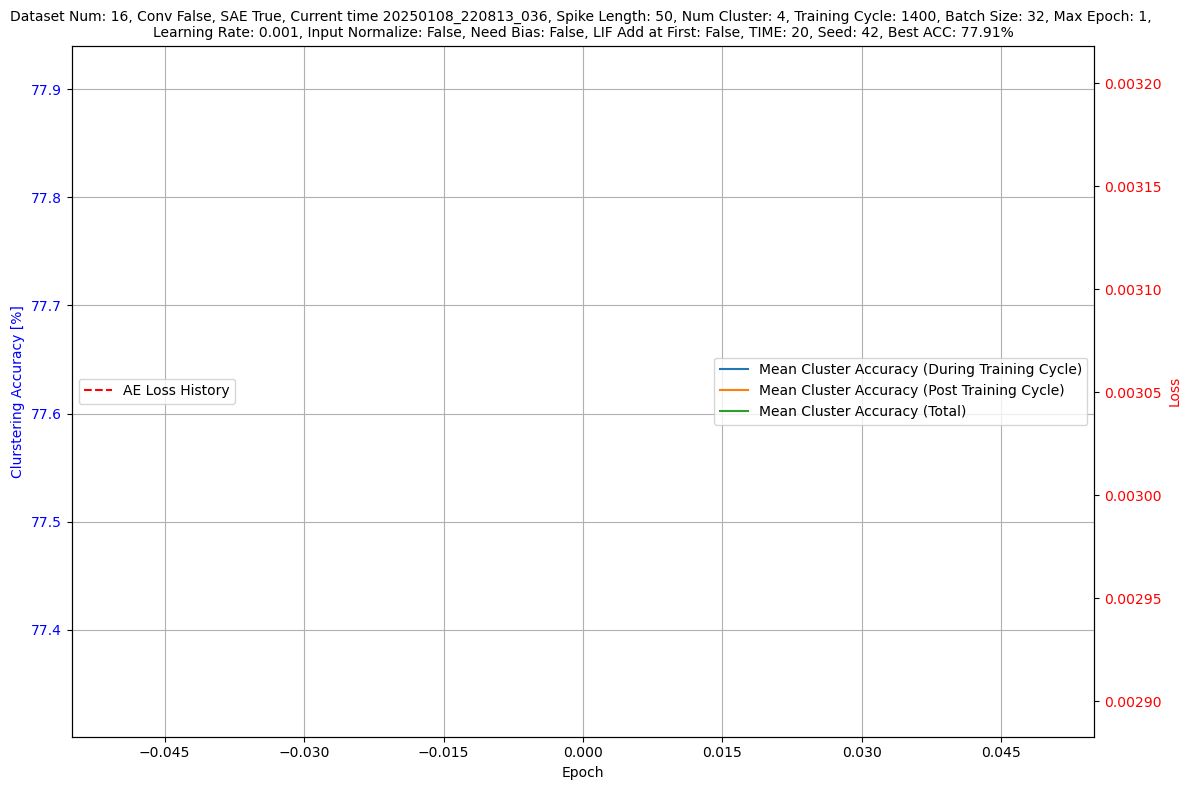

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pickle
import json

# current_time = '20250102_225243_972'

with open(f"result_save/cluster_accuracy_history_{current_time}.pkl", "rb") as f:
    data = pickle.load(f)


# JSON으로 저장
with open(f"result_save/cluster_accuracy_history_{current_time}.json", 'r') as f:
    loaded_hyperparameters = json.load(f)

loss_history = data['loss_history']
mean_cluster_accuracy_during_training_cycle_all_dataset_history = data['mean_cluster_accuracy_during_training_cycle_all_dataset_history']
mean_cluster_accuracy_post_training_cycle_all_dataset_history = data['mean_cluster_accuracy_post_training_cycle_all_dataset_history']
mean_cluster_accuracy_total_all_dataset_history = data['mean_cluster_accuracy_total_all_dataset_history']
print(data)
max_acc = 0
for i in mean_cluster_accuracy_post_training_cycle_all_dataset_history:
    if i[1] > max_acc:
        max_acc = i[1]

# 설정 정보 제목 작성
title = (
    f"Dataset Num: {loaded_hyperparameters['dataset_num']}, Conv {loaded_hyperparameters['Conv_net']}, SAE {loaded_hyperparameters['SAE_net']}, Current time {loaded_hyperparameters['current_time']}, Spike Length: {loaded_hyperparameters['spike_length']}, Num Cluster: {loaded_hyperparameters['num_cluster']}, "
    f"Training Cycle: {loaded_hyperparameters['training_cycle']}, Batch Size: {loaded_hyperparameters['batch_size']}, Max Epoch: {loaded_hyperparameters['max_epoch']}, \n"
    f"Learning Rate: {loaded_hyperparameters['learning_rate']}, Input Normalize: {loaded_hyperparameters['normalize_on']}, Need Bias: {loaded_hyperparameters['need_bias']}, "
    f"LIF Add at First: {loaded_hyperparameters['lif_add_at_first']}, TIME: {loaded_hyperparameters['TIME']}, Seed: {loaded_hyperparameters['my_seed']}, Best ACC: {max_acc:.2f}%"
)

# 데이터 리스트와 라벨 설정 (Loss 제외)
data_list = [
    ("Mean Cluster Accuracy (During Training Cycle)", mean_cluster_accuracy_during_training_cycle_all_dataset_history),
    ("Mean Cluster Accuracy (Post Training Cycle)", mean_cluster_accuracy_post_training_cycle_all_dataset_history),
    ("Mean Cluster Accuracy (Total)", mean_cluster_accuracy_total_all_dataset_history),
]

# 플롯 생성
fig, ax1 = plt.subplots(figsize=(12, 8))

# 첫 번째 y축: Accuracy 관련 데이터
for label, data in data_list:
    epochs, values = zip(*data)  # epoch, value 분리
    ax1.plot(epochs, values, label=label)

ax1.set_xlabel("Epoch")
ax1.set_ylabel("Clurstering Accuracy [%]", color="blue")
ax1.tick_params(axis="y", labelcolor="blue")
ax1.legend(loc="center right")
ax1.grid(True)

# x축을 정수만 표시하도록 설정
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))

# 두 번째 y축: Loss History
ax2 = ax1.twinx()
epochs, values = zip(*loss_history)
ax2.plot(epochs, values, label="AE Loss History", color="red", linestyle="--")
ax2.set_ylabel("Loss", color="red")
ax2.tick_params(axis="y", labelcolor="red")
ax2.legend(loc="center left")

# 제목 추가
plt.title(title, fontsize=10)
plt.tight_layout()
plt.savefig(f'net_save/{current_time}', dpi=300, bbox_inches="tight")  # dpi=300은 고해상도로 저장, bbox_inches="tight"는 여백 최소화
plt.show()
